In [27]:
import matplotlib.pyplot as plt
import numpy

from rbatools.rba_session import SessionRBA
from rbatools.rba_problem_matrix import ProblemMatrix
from sample_models import sample_model_loader
from scipy.sparse import coo_matrix

In [28]:
#model_filename = '../../../Bacterial-RBA-models/Bacillus-subtilis-168-WT' #if you have cloned the Bacterial-RBA-models repo
model_filename = sample_model_loader.get_sample_model(model='Bacillus-subtilis-168-WT') #use included sample model

Simulation = SessionRBA(xml_dir=model_filename, lp_solver="cplex")


In [29]:
def run_glucose_screen(Simulation,glcs):
    Results_glc_screen = {"Mu":[],"M_glc":[],"M_o2":[],"M_ac":[]} # generate empty structure to store results of interest
    for glc_conc in glcs: # iterate through all generated glucose concentrations
        Simulation.set_medium({'M_glc':glc_conc}) #set glucose concnetration to respective value
        #determine growth-optimal state and maximum growth-rate:
        mumax = Simulation.find_max_growth_rate()
        if mumax!=0:
            J_ex = Simulation.return_exchange_fluxes() # obtain corresponding exchange-fluxes
            # write growth-rate and exchanges for glucose, oxygen and acetate to storing structure:
            for i in Results_glc_screen.keys():
                if i == "Mu":
                    Results_glc_screen["Mu"].append(mumax)
                else:
                    if i in J_ex.keys():
                        Results_glc_screen[i].append(J_ex[i])
                    else:
                        Results_glc_screen[i].append(0)
        else:
            for i in Results_glc_screen.keys():
                if i == "Mu":
                    Results_glc_screen["Mu"].append(numpy.nan)
                else:
                    Results_glc_screen[i].append(numpy.nan)

    return(Results_glc_screen)


In [30]:
def plot_glc_screen_results(glcs,Results_glc_screen):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=5, alpha=0.6, color="dimgray")
    ax.legend(["Monod curve"], loc="upper left", fontsize=12, frameon=False)
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=13, alpha=0.6, color="gainsboro")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=10, alpha=0.6, color="lightgray")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=7, alpha=0.6, color="silver")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=5, alpha=0.6, color="gray")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=2, alpha=0.6, color="dimgray")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=1, alpha=0.6, color="black")
    ax2=ax.twinx()
    ax2.plot(glcs, [i for i in Results_glc_screen["M_ac"]], linewidth=4,
             color="mediumseagreen", alpha=0.9)
    ax2.plot(glcs, [-i for i in Results_glc_screen["M_o2"]], linewidth=4, 
             color="indianred", alpha=0.9, linestyle=(0, (1, 1)))
    ax2.plot(glcs, [-i for i in Results_glc_screen["M_glc"]], linewidth=4, 
             color="steelblue", alpha=0.9, linestyle=(0, (3, 1, 1, 1)))
    ax2.legend(["$Acetate$ excretion","$O_2$ uptake","$Glucose$ uptake"], 
               loc="lower right", fontsize=12, frameon=False)

    ax.set_title("Glucose dependent growth-rate and exchange fluxes", fontsize=15)
    ax.set_xlabel("Glucose concentration (mM)", fontsize=12)
    ax.tick_params(axis='y', labelcolor="dimgrey")
    ax2.tick_params(axis='y', labelcolor="black")
    ax.set_ylabel("Growth rate ($h^{-1}$)", color="dimgrey", fontsize=12)
    ax2.set_ylabel('Exchange fluxes ($\\frac{mmol}{h \\times g_{DW}}$)', 
                   color="black", fontsize=12)
    plt.tight_layout()
    plt.show()


In [31]:
def plot_o2_glc_uptake_ratio(glcs,Results_glc_screen):
    o2_glc_ratio_original=[Results_glc_screen["M_o2"][i]/Results_glc_screen["M_glc"][i] for i in range(len(glcs))]
    plt.scatter(glcs,o2_glc_ratio_original)
    plt.title("Ratio $O_2$ over Glucose uptake")
    plt.xlabel("Glucose concentration (mM)")
    plt.ylabel("$J^{ex}_{O2}$/$J^{ex}_{GLC}$")
    plt.show()

In [34]:
glcs = [0.005+(i*0.005) for i in range(13)] # generate glucose concentration intervals


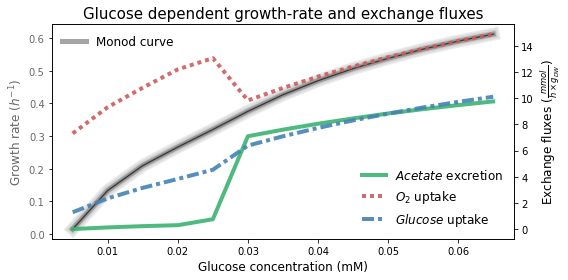

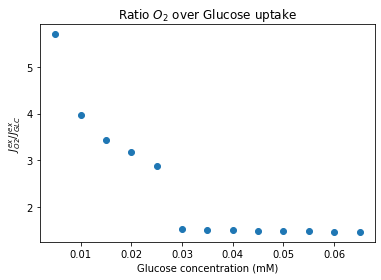

In [35]:
Simulation.reload_model()
Results_glc_screen_original=run_glucose_screen(Simulation,glcs)

plot_glc_screen_results(glcs,Results_glc_screen_original)
plot_o2_glc_uptake_ratio(glcs,Results_glc_screen_original)

In [36]:
Simulation.reload_model()
imposed_o2_glc_ratio=5

matrix_to_add=ProblemMatrix()
matrix_to_add.row_names=['o2_glc_ratio']
matrix_to_add.col_names=['To2','TptsG']
matrix_to_add.A=coo_matrix(numpy.array([[1,-imposed_o2_glc_ratio]]))
matrix_to_add.b=numpy.array([0])
matrix_to_add.row_signs=['E']

original_objective_coefficients=Simulation.Problem.get_objective(['To2','TptsG'])
original_lb_coefficients=Simulation.Problem.get_lb(['To2','TptsG'])
original_ub_coefficients=Simulation.Problem.get_ub(['To2','TptsG'])
matrix_to_add.f=numpy.array([original_objective_coefficients['To2'],original_objective_coefficients['TptsG']])
matrix_to_add.LB=numpy.array([original_lb_coefficients['To2'],original_lb_coefficients['TptsG']])
matrix_to_add.UB=numpy.array([original_ub_coefficients['To2'],original_ub_coefficients['TptsG']])

Simulation.Problem.LP.add_matrix(matrix=matrix_to_add)


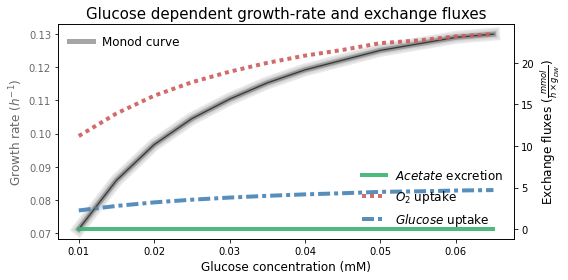

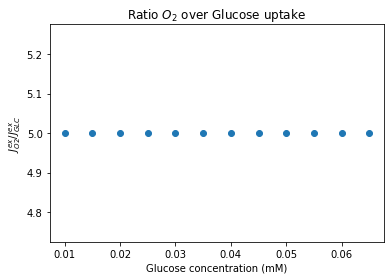

In [37]:
Results_glc_screen_ratio_5=run_glucose_screen(Simulation,glcs)

plot_glc_screen_results(glcs,Results_glc_screen_ratio_5)
plot_o2_glc_uptake_ratio(glcs,Results_glc_screen_ratio_5)

In [38]:
Simulation.reload_model()
imposed_o2_glc_ratio=3

matrix_to_add=ProblemMatrix()
matrix_to_add.row_names=['o2_glc_ratio']
matrix_to_add.col_names=['To2','TptsG']
matrix_to_add.A=coo_matrix(numpy.array([[1,-imposed_o2_glc_ratio]]))
matrix_to_add.b=numpy.array([0])
matrix_to_add.row_signs=['E']

original_objective_coefficients=Simulation.Problem.get_objective(['To2','TptsG'])
original_lb_coefficients=Simulation.Problem.get_lb(['To2','TptsG'])
original_ub_coefficients=Simulation.Problem.get_ub(['To2','TptsG'])
matrix_to_add.f=numpy.array([original_objective_coefficients['To2'],original_objective_coefficients['TptsG']])
matrix_to_add.LB=numpy.array([original_lb_coefficients['To2'],original_lb_coefficients['TptsG']])
matrix_to_add.UB=numpy.array([original_ub_coefficients['To2'],original_ub_coefficients['TptsG']])

Simulation.Problem.LP.add_matrix(matrix=matrix_to_add)


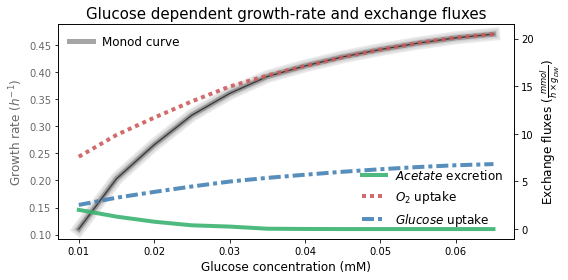

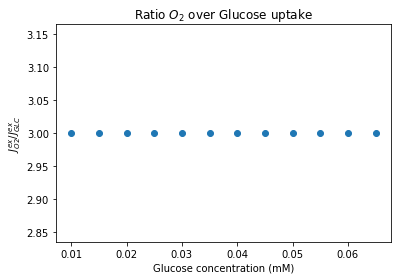

In [39]:
Results_glc_screen_ratio_3=run_glucose_screen(Simulation,glcs)

plot_glc_screen_results(glcs,Results_glc_screen_ratio_3)
plot_o2_glc_uptake_ratio(glcs,Results_glc_screen_ratio_3)
